In [1]:
import pandas as pd
import geopandas as gpd
from geopandas import GeoSeries
from osgeo import osr
from osgeo import ogr
import gdal
from shapely.geometry import LineString, shape, mapping
import fiona
from shapely import affinity
import rasterio
import matplotlib.pyplot as plt
import traceback
import datetime
import numpy as np
from rasterio.plot import show
import os
import warnings
warnings.filterwarnings("ignore")

# Loading of data and setting of parameters

<AxesSubplot:title={'center':'hillshade'}>

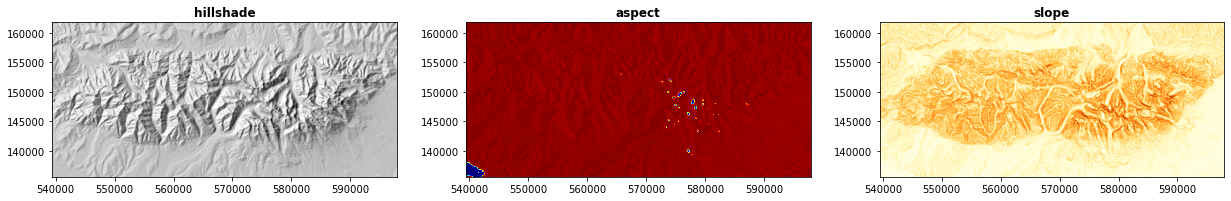

In [2]:
station_meters = 250 # distance beetween sampling points
conNum = 35 # number of countorus
flat_areas_slope = 4 # flat areas - below this slope areas will not be drawn
folder_shp = r'.\shp'
folder_res = r'.\results'

raster_slope = rasterio.open(r'.\dem\dem_tatras_slope.tif')
raster_aspect = rasterio.open(r'.\dem\dem_tatras_aspect.tif')
raster_hs = rasterio.open(r'.\dem\dem_tatras_hs.tif')
raster_dem = gdal.Open(r'.\dem\dem_tatras.tif')
fig, (axr, axg, axb) = plt.subplots(1,3, figsize=(21,7))

show((raster_slope, 1), ax=axb, cmap='YlOrBr', title='slope')
show((raster_aspect, 1), ax=axg, cmap='jet', title='aspect')
show((raster_hs, 1), ax=axr, cmap='gray', title='hillshade')

# creation of contours

Maximum dem elevation: 2608.31, minimum dem elevation: 554.64


<AxesSubplot:>

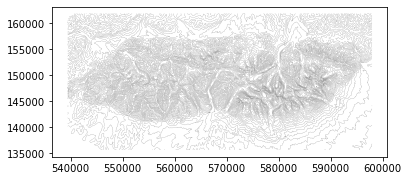

In [3]:
rasterBand = raster_dem.GetRasterBand(1)
proj = osr.SpatialReference(wkt=raster_dem.GetProjection())

elevArray = rasterBand.ReadAsArray()
demNan = -340282306073709652508363335590014353408.00
demMax = elevArray.max()
demMin = elevArray[elevArray!=demNan].min()
print("Maximum dem elevation: %.2f, minimum dem elevation: %.2f"%(demMax,demMin))
contourPath = f'{folder_shp}\contoursDefined_{conNum}.shp'
contourDs = ogr.GetDriverByName("ESRI Shapefile").CreateDataSource(contourPath)
contourShp = contourDs.CreateLayer(str(conNum), proj)

# define fields of id and elev
fieldDef = ogr.FieldDefn("ID", ogr.OFTInteger)
contourShp.CreateField(fieldDef)
fieldDef = ogr.FieldDefn("elev", ogr.OFTReal)
contourShp.CreateField(fieldDef)

# define number of contours and range
conList =[int(x) for x in np.linspace(demMin,demMax,conNum)]
gdal.ContourGenerate(rasterBand, int(demMin), int(demMax), conList, 1, demNan, contourShp, 0, 1)

contourDs.Destroy()
contour_gdf = gpd.read_file(f'{folder_shp}/contoursDefined_{conNum}.shp')
contour_gdf.plot(linewidth=0.2, color='gray')

# creation of station points on contours, every X meters

2021-10-17 10:03:33.670499
2021-10-17 10:04:11.473406, station points processed, total number of points: 32984


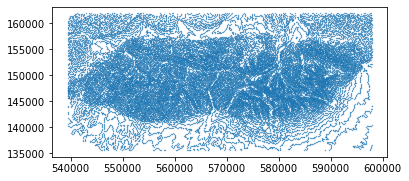

In [4]:
print(datetime.datetime.now())
line = fiona.open(f'{folder_shp}/contoursDefined_{conNum}.shp')
no_rows = len(line)

list_points = []
for feature in range(0,no_rows):
    points_st = (f'{folder_shp}/points_countur.shp')
    firstline = line.next()
    # transform to shapely geometry
    first = shape(firstline['geometry'])
    # length of the LineString
    length = first.length

    # creation of the resulting shapefile
    schema = {'geometry': 'Point','properties': {'id': 'int'},}
    with fiona.open(points_st, 'w', 'ESRI Shapefile', schema)  as output:
        # create points every station_meters  along the line
        for distance in range(0, int(length), station_meters):
            point = first.interpolate(distance)
            output.write({'geometry':mapping(point),'properties': {'id':1}})
    points_gdf = gpd.read_file(points_st)
    list_points.append(points_gdf)
    os.remove(f'{folder_shp}/points_countur.shp')

station_points_merged = pd.concat(list_points)
station_points_merged['x'] = station_points_merged['geometry'].apply(lambda p: p.x)
station_points_merged['y'] = station_points_merged['geometry'].apply(lambda p: p.y)
station_points_merged.to_file(fr'{folder_shp}/station_points_merged_{station_meters}.shp')
station_points_merged.plot(markersize=0.1)
print(f'{datetime.datetime.now()}, station points processed, total number of points: {station_points_merged.shape[0]}')

# extract rasters values to station points

2021-10-17 10:04:14.875013
2021-10-17 10:04:37.972851


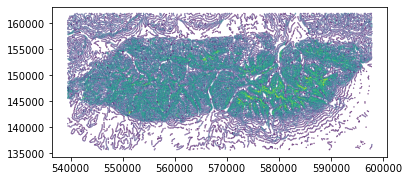

In [5]:
station_points_merged = gpd.read_file(fr'{folder_shp}/station_points_merged_{station_meters}.shp')
station_points_merged['x'] = station_points_merged['geometry'].apply(lambda p: p.x)
station_points_merged['y'] = station_points_merged['geometry'].apply(lambda p: p.y)
print(datetime.datetime.now())

for idx, row in station_points_merged.iterrows():
    try:
        for val in raster_hs.sample([(row.x, row.y)]):
            station_points_merged.at[idx, 'hs'] = val[0]
    except:
        pass
    try:
        for val in raster_aspect.sample([(row.x, row.y)]):
            station_points_merged.at[idx, 'aspect'] = val[0]
    except:
        pass
    try:
        for val in raster_slope.sample([(row.x, row.y)]):
                station_points_merged.at[idx, 'slope'] = val[0]
    except:
        pass

station_points_merged = station_points_merged.dropna()
station_points_merged = station_points_merged.loc[station_points_merged.slope > flat_areas_slope]
station_points_merged.to_file(fr'{folder_shp}\points_slope_aspect_{conNum}_{station_meters}.shp')
station_points_merged.plot(column='slope', markersize=0.1)
print(datetime.datetime.now())

# create shrafure line shapes

In [6]:
station_points_merged = gpd.read_file(fr'{folder_shp}\points_slope_aspect_{conNum}_{station_meters}.shp')
multiplier = 5
print(datetime.datetime.now())
list_lines = []
for point in station_points_merged.itertuples():
    try:
        input_l = LineString([(point.x - multiplier * point.slope, point.y), (point.x + multiplier * point.slope, point.y)])
        input_l_rot = affinity.rotate(input_l, point.aspect, (point.x, point.y))
        line_gs = GeoSeries(input_l_rot)
        line_gdf = gpd.GeoDataFrame(geometry=line_gs)
        line_gdf['hs'] = point.hs
        list_lines.append(line_gdf)
    except Exception as e:
        traceback.print_exc()

gdf_lines = pd.concat(list_lines)
gdf_lines.to_file(fr'{folder_res}\l_{conNum}_{station_meters}_{multiplier}.shp')
print(datetime.datetime.now())

2021-10-17 10:04:41.152110
2021-10-17 10:05:52.346921


# plot map

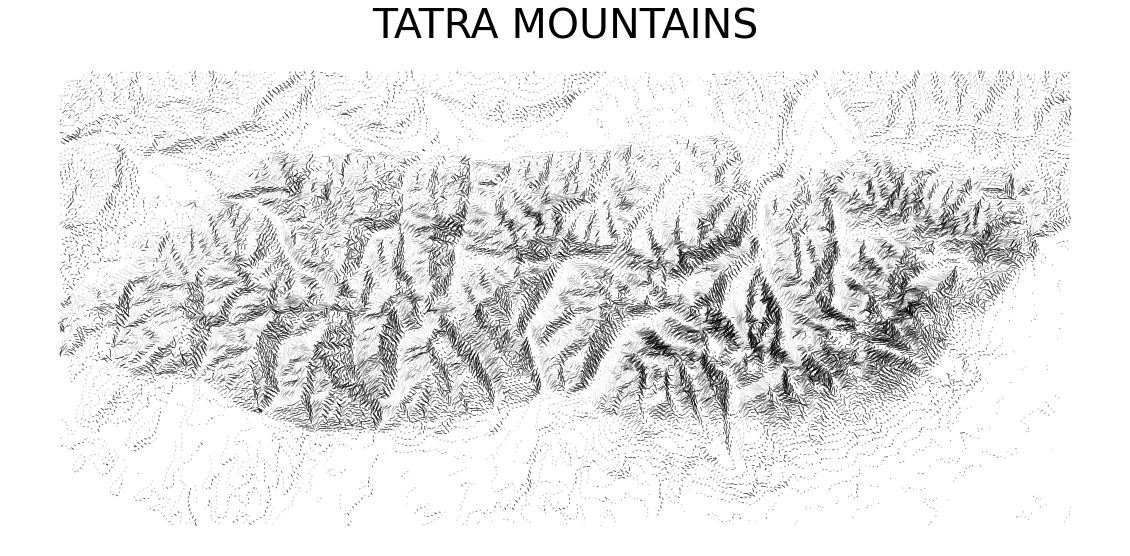

In [7]:
line_width = 0.9
transparency = 0.7
fig, ax = plt.subplots(figsize=(20,15))
map_title = 'TATRA MOUNTAINS'
hfont = {'fontname':'DejaVu Sans'}
ax.set_title(map_title, fontsize=41, **hfont)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.set_frame_on(False)
gdf_lines.plot(ax = ax, column='hs', linewidth=line_width, alpha=transparency, cmap='gray', vmin=150, vmax=255)
plt.savefig(fr'{folder_res}\l_{map_title}_{conNum}_{station_meters}_{multiplier}_{line_width}.jpg')